# Train Model on Baron - Human Dataset

In this notebook, we're going to train our model using the Baron Human dataset. 

This assumes that you've made the graph using the ```Infer GRN.ipynb``` code.

In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Data, Dataset
from tqdm import tqdm
from datasetbaronhuman import BaronHumanDataset
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

Torch version: 1.9.0+cu102
Cuda available: True
Torch geometric version: 1.7.1


In [2]:
dataset = BaronHumanDataset("/gpfs/data/rsingh47/hzaki1/data-baron-human")

100%|██████████| 181366/181366 [00:12<00:00, 14057.97it/s]


In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: BaronHumanDataset(8569):
Number of graphs: 8569
Number of features: 1

Data(edge_index=[2, 181366], x=[17499], y=[1])
Number of nodes: 17499
Number of edges: 181366
Average node degree: 10.36
Contains isolated nodes: True
Contains self-loops: False
Is undirected: False


In [5]:
shuffle_index = np.loadtxt('shuffle_index_BaronHuman.txt')
shuffle_index = shuffle_index.astype(np.int32)
train_size, val_size = int(len(shuffle_index)* 0.8), int(len(shuffle_index)* 0.9)
train_data = [dataset[i] for i in shuffle_index[0:train_size]]
val_data = [dataset[i] for i in shuffle_index[train_size: val_size]]
test_data =  [dataset[i] for i in shuffle_index[val_size:]]

In [ ]:
# torch.manual_seed(12345)
# dataset = dataset.shuffle()

# #train_dataset = torch.load('trainDataset.pt')
# #test_dataset = torch.load('testDataset.pt')

# train_dataset = dataset[:6856]
# test_dataset = dataset[6856:]
# #test_dataset = dataset[-12:]


# # train_dataset = dataset[:40]
# # test_dataset = dataset[40:60]

# print(f'Number of training graphs: {len(train_dataset)}')
# print(f'Number of test graphs: {len(test_dataset)}')

In [6]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_data, batch_size=30, shuffle=True)
val_loader = DataLoader(val_data, batch_size=30, shuffle=True)
test_loader = DataLoader(test_data, batch_size=30, shuffle=False)

In [7]:
from gcnmodel import GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=128, data=dataset, output_size=14).to(device)
print(model)

GCN(
  (conv1): SAGEConv(1, 128)
  (conv2): SAGEConv(128, 128)
  (conv3): SAGEConv(128, 128)
  (lin): Linear(in_features=128, out_features=14, bias=True)
)


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    avgLoss = 0
    for data in tqdm(train_loader, total=229):  # Iterate in batches over the training dataset.
        data.x = torch.reshape(data.x, (data.x.shape[0], 1))
        data.x = data.x.type(torch.FloatTensor)
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)# Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        avgLoss += loss
    return avgLoss / 229

def test(loader):
    model.eval()

    correct = 0
    avgAUC = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.x = torch.reshape(data.x, (data.x.shape[0], 1))
        data.x = data.x.type(torch.FloatTensor)
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        avgAUCbatch = 0
        aucCounter = 0
        one_hot = np.eye(14)[data.y.cpu()]
        for i in range(0,14):
            try:
                roc = roc_auc_score(one_hot[:,i], out.cpu().detach().numpy()[:,i])
                avgAUCbatch += roc
                aucCounter +=1
            except Exception as e:
                continue
        if aucCounter == 0:
            continue
        avgAUC += avgAUCbatch/aucCounter
    return correct / len(loader.dataset), avgAUC / len(loader)  # Derive ratio of correct predictions.


for epoch in range(1, 250):
    loss = train()
    train_acc, trainAUC = test(train_loader)
    test_acc,testAUC = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train AUC: {trainAUC:.4f}, Test Acc: {test_acc:.4f}, Test Auc: {testAUC:.4f}, Loss: {loss:.4f}')

  0%|          | 1/229 [00:00<00:30,  7.46it/s]

Epoch: 001, Train Acc: 0.4624, Train AUC: 0.7457, Test Acc: 0.4784, Test Auc: 0.7442, Loss: 3.1140


  0%|          | 1/229 [00:00<00:30,  7.38it/s]

Epoch: 002, Train Acc: 0.5179, Train AUC: 0.7810, Test Acc: 0.5344, Test Auc: 0.7783, Loss: 1.5396


  0%|          | 1/229 [00:00<00:30,  7.44it/s]

Epoch: 003, Train Acc: 0.5381, Train AUC: 0.7766, Test Acc: 0.5566, Test Auc: 0.7705, Loss: 1.5051


  0%|          | 1/229 [00:00<00:28,  7.95it/s]

Epoch: 004, Train Acc: 0.5498, Train AUC: 0.7740, Test Acc: 0.5601, Test Auc: 0.7618, Loss: 1.4639


  0%|          | 1/229 [00:00<00:28,  8.10it/s]

Epoch: 005, Train Acc: 0.5733, Train AUC: 0.7765, Test Acc: 0.5928, Test Auc: 0.7618, Loss: 1.4355


  0%|          | 1/229 [00:00<00:29,  7.69it/s]

Epoch: 006, Train Acc: 0.5592, Train AUC: 0.8058, Test Acc: 0.5508, Test Auc: 0.7977, Loss: 1.4027


  0%|          | 1/229 [00:00<00:30,  7.43it/s]

Epoch: 007, Train Acc: 0.5558, Train AUC: 0.7995, Test Acc: 0.5624, Test Auc: 0.7863, Loss: 1.3748


  0%|          | 1/229 [00:00<00:31,  7.18it/s]

Epoch: 008, Train Acc: 0.6121, Train AUC: 0.8050, Test Acc: 0.6126, Test Auc: 0.7959, Loss: 1.3562


  0%|          | 1/229 [00:00<00:29,  7.74it/s]

Epoch: 009, Train Acc: 0.5985, Train AUC: 0.8053, Test Acc: 0.5939, Test Auc: 0.7915, Loss: 1.3442


  0%|          | 1/229 [00:00<00:31,  7.16it/s]

Epoch: 010, Train Acc: 0.5555, Train AUC: 0.7991, Test Acc: 0.5543, Test Auc: 0.7841, Loss: 1.4116


  0%|          | 1/229 [00:00<00:31,  7.27it/s]

Epoch: 011, Train Acc: 0.6044, Train AUC: 0.8053, Test Acc: 0.6243, Test Auc: 0.7962, Loss: 1.3433


  0%|          | 1/229 [00:00<00:29,  7.62it/s]

Epoch: 012, Train Acc: 0.6280, Train AUC: 0.8070, Test Acc: 0.6371, Test Auc: 0.7952, Loss: 1.3649


  0%|          | 1/229 [00:00<00:31,  7.21it/s]

Epoch: 013, Train Acc: 0.6232, Train AUC: 0.8049, Test Acc: 0.6359, Test Auc: 0.7930, Loss: 1.3253


  0%|          | 1/229 [00:00<00:31,  7.27it/s]

Epoch: 014, Train Acc: 0.6375, Train AUC: 0.8035, Test Acc: 0.6476, Test Auc: 0.7890, Loss: 1.2940


  0%|          | 1/229 [00:00<00:31,  7.31it/s]

Epoch: 015, Train Acc: 0.6006, Train AUC: 0.8149, Test Acc: 0.6056, Test Auc: 0.8019, Loss: 1.2781


  0%|          | 1/229 [00:00<00:31,  7.20it/s]

Epoch: 016, Train Acc: 0.5999, Train AUC: 0.8092, Test Acc: 0.6009, Test Auc: 0.7964, Loss: 1.2476


  0%|          | 1/229 [00:00<00:31,  7.24it/s]

Epoch: 017, Train Acc: 0.6408, Train AUC: 0.8246, Test Acc: 0.6429, Test Auc: 0.8146, Loss: 1.2778


  0%|          | 1/229 [00:00<00:31,  7.26it/s]

Epoch: 018, Train Acc: 0.6136, Train AUC: 0.8288, Test Acc: 0.6126, Test Auc: 0.8158, Loss: 1.2240


  0%|          | 1/229 [00:00<00:31,  7.23it/s]

Epoch: 019, Train Acc: 0.6340, Train AUC: 0.8337, Test Acc: 0.6348, Test Auc: 0.8200, Loss: 1.2134


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 020, Train Acc: 0.6671, Train AUC: 0.8348, Test Acc: 0.6768, Test Auc: 0.8243, Loss: 1.1832


  0%|          | 1/229 [00:00<00:31,  7.30it/s]

Epoch: 021, Train Acc: 0.6635, Train AUC: 0.8426, Test Acc: 0.6593, Test Auc: 0.8296, Loss: 1.1816


  0%|          | 1/229 [00:00<00:29,  7.79it/s]

Epoch: 022, Train Acc: 0.6573, Train AUC: 0.8383, Test Acc: 0.6569, Test Auc: 0.8230, Loss: 1.1685


  0%|          | 1/229 [00:00<00:29,  7.77it/s]

Epoch: 023, Train Acc: 0.6942, Train AUC: 0.8464, Test Acc: 0.6849, Test Auc: 0.8371, Loss: 1.1290


  0%|          | 1/229 [00:00<00:31,  7.21it/s]

Epoch: 024, Train Acc: 0.6336, Train AUC: 0.8345, Test Acc: 0.6429, Test Auc: 0.8204, Loss: 1.1583


  0%|          | 1/229 [00:00<00:29,  7.71it/s]

Epoch: 025, Train Acc: 0.6624, Train AUC: 0.8444, Test Acc: 0.6581, Test Auc: 0.8254, Loss: 1.1741


  0%|          | 1/229 [00:00<00:31,  7.19it/s]

Epoch: 026, Train Acc: 0.6608, Train AUC: 0.8354, Test Acc: 0.6709, Test Auc: 0.8182, Loss: 1.1380


  0%|          | 1/229 [00:00<00:31,  7.27it/s]

Epoch: 027, Train Acc: 0.6617, Train AUC: 0.8496, Test Acc: 0.6511, Test Auc: 0.8305, Loss: 1.1265


  0%|          | 1/229 [00:00<00:31,  7.24it/s]

Epoch: 028, Train Acc: 0.6957, Train AUC: 0.8593, Test Acc: 0.6954, Test Auc: 0.8413, Loss: 1.1180


  0%|          | 1/229 [00:00<00:30,  7.42it/s]

Epoch: 029, Train Acc: 0.7002, Train AUC: 0.8543, Test Acc: 0.6966, Test Auc: 0.8381, Loss: 1.0906


  0%|          | 1/229 [00:00<00:32,  7.11it/s]

Epoch: 030, Train Acc: 0.7091, Train AUC: 0.8578, Test Acc: 0.6919, Test Auc: 0.8424, Loss: 1.0707


  0%|          | 1/229 [00:00<00:31,  7.23it/s]

Epoch: 031, Train Acc: 0.7098, Train AUC: 0.8704, Test Acc: 0.6908, Test Auc: 0.8540, Loss: 1.0458


  0%|          | 1/229 [00:00<00:29,  7.72it/s]

Epoch: 032, Train Acc: 0.7419, Train AUC: 0.8644, Test Acc: 0.7165, Test Auc: 0.8430, Loss: 1.0397


  0%|          | 1/229 [00:00<00:29,  7.63it/s]

Epoch: 033, Train Acc: 0.7307, Train AUC: 0.8695, Test Acc: 0.6908, Test Auc: 0.8471, Loss: 1.0087


  0%|          | 1/229 [00:00<00:30,  7.55it/s]

Epoch: 034, Train Acc: 0.7068, Train AUC: 0.8844, Test Acc: 0.6861, Test Auc: 0.8608, Loss: 0.9909


  0%|          | 1/229 [00:00<00:31,  7.21it/s]

Epoch: 035, Train Acc: 0.7498, Train AUC: 0.8894, Test Acc: 0.7095, Test Auc: 0.8618, Loss: 0.9635


  0%|          | 1/229 [00:00<00:31,  7.27it/s]

Epoch: 036, Train Acc: 0.7507, Train AUC: 0.9117, Test Acc: 0.7141, Test Auc: 0.8888, Loss: 0.9535


  0%|          | 1/229 [00:00<00:30,  7.58it/s]

Epoch: 037, Train Acc: 0.7447, Train AUC: 0.9043, Test Acc: 0.7106, Test Auc: 0.8759, Loss: 0.9192


  0%|          | 1/229 [00:00<00:31,  7.15it/s]

Epoch: 038, Train Acc: 0.7653, Train AUC: 0.9061, Test Acc: 0.7316, Test Auc: 0.8840, Loss: 0.8985


  0%|          | 1/229 [00:00<00:31,  7.28it/s]

Epoch: 039, Train Acc: 0.7555, Train AUC: 0.9071, Test Acc: 0.7305, Test Auc: 0.8790, Loss: 0.8858


  0%|          | 1/229 [00:00<00:30,  7.39it/s]

Epoch: 040, Train Acc: 0.7771, Train AUC: 0.9141, Test Acc: 0.7445, Test Auc: 0.8897, Loss: 0.8522


  0%|          | 1/229 [00:00<00:31,  7.23it/s]

Epoch: 041, Train Acc: 0.7975, Train AUC: 0.9169, Test Acc: 0.7655, Test Auc: 0.8936, Loss: 0.8250


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 042, Train Acc: 0.7829, Train AUC: 0.9259, Test Acc: 0.7445, Test Auc: 0.9032, Loss: 0.7934


  0%|          | 1/229 [00:00<00:29,  7.69it/s]

Epoch: 043, Train Acc: 0.7778, Train AUC: 0.9213, Test Acc: 0.7690, Test Auc: 0.8952, Loss: 0.8072


  0%|          | 1/229 [00:00<00:29,  7.85it/s]

Epoch: 044, Train Acc: 0.8118, Train AUC: 0.9318, Test Acc: 0.7713, Test Auc: 0.9078, Loss: 0.7743


  0%|          | 1/229 [00:00<00:29,  7.83it/s]

Epoch: 045, Train Acc: 0.8076, Train AUC: 0.9268, Test Acc: 0.7725, Test Auc: 0.9000, Loss: 0.7675


  0%|          | 1/229 [00:00<00:31,  7.17it/s]

Epoch: 046, Train Acc: 0.8324, Train AUC: 0.9328, Test Acc: 0.7981, Test Auc: 0.9055, Loss: 0.7393


  0%|          | 1/229 [00:00<00:31,  7.29it/s]

Epoch: 047, Train Acc: 0.8163, Train AUC: 0.9361, Test Acc: 0.7771, Test Auc: 0.9137, Loss: 0.7284


  0%|          | 1/229 [00:00<00:31,  7.23it/s]

Epoch: 048, Train Acc: 0.7457, Train AUC: 0.9422, Test Acc: 0.7130, Test Auc: 0.9215, Loss: 0.7044


  0%|          | 1/229 [00:00<00:31,  7.20it/s]

Epoch: 049, Train Acc: 0.8395, Train AUC: 0.9398, Test Acc: 0.7911, Test Auc: 0.9152, Loss: 0.7107


  0%|          | 1/229 [00:00<00:31,  7.13it/s]

Epoch: 050, Train Acc: 0.8464, Train AUC: 0.9401, Test Acc: 0.8028, Test Auc: 0.9114, Loss: 0.6829


  0%|          | 1/229 [00:00<00:31,  7.19it/s]

Epoch: 051, Train Acc: 0.8465, Train AUC: 0.9438, Test Acc: 0.8133, Test Auc: 0.9218, Loss: 0.6670


  0%|          | 1/229 [00:00<00:32,  7.10it/s]

Epoch: 052, Train Acc: 0.8389, Train AUC: 0.9392, Test Acc: 0.7806, Test Auc: 0.9124, Loss: 0.6669


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 053, Train Acc: 0.8563, Train AUC: 0.9416, Test Acc: 0.8121, Test Auc: 0.9175, Loss: 0.6589


  0%|          | 1/229 [00:00<00:29,  7.76it/s]

Epoch: 054, Train Acc: 0.8544, Train AUC: 0.9447, Test Acc: 0.8075, Test Auc: 0.9235, Loss: 0.6510


  0%|          | 1/229 [00:00<00:29,  7.62it/s]

Epoch: 055, Train Acc: 0.8530, Train AUC: 0.9487, Test Acc: 0.8133, Test Auc: 0.9238, Loss: 0.6411


  0%|          | 1/229 [00:00<00:31,  7.17it/s]

Epoch: 056, Train Acc: 0.8525, Train AUC: 0.9511, Test Acc: 0.8051, Test Auc: 0.9280, Loss: 0.6252


  0%|          | 1/229 [00:00<00:30,  7.36it/s]

Epoch: 057, Train Acc: 0.8543, Train AUC: 0.9481, Test Acc: 0.8191, Test Auc: 0.9233, Loss: 0.6151


  0%|          | 1/229 [00:00<00:29,  7.61it/s]

Epoch: 058, Train Acc: 0.8521, Train AUC: 0.9498, Test Acc: 0.8098, Test Auc: 0.9248, Loss: 0.6166


  0%|          | 1/229 [00:00<00:29,  7.63it/s]

Epoch: 059, Train Acc: 0.8827, Train AUC: 0.9559, Test Acc: 0.8343, Test Auc: 0.9365, Loss: 0.6240


  0%|          | 1/229 [00:00<00:31,  7.16it/s]

Epoch: 060, Train Acc: 0.8862, Train AUC: 0.9517, Test Acc: 0.8320, Test Auc: 0.9303, Loss: 0.5957


  0%|          | 1/229 [00:00<00:31,  7.25it/s]

Epoch: 061, Train Acc: 0.8814, Train AUC: 0.9553, Test Acc: 0.8425, Test Auc: 0.9343, Loss: 0.5949


  0%|          | 1/229 [00:00<00:31,  7.20it/s]

Epoch: 062, Train Acc: 0.8709, Train AUC: 0.9577, Test Acc: 0.8378, Test Auc: 0.9362, Loss: 0.5646


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 063, Train Acc: 0.8877, Train AUC: 0.9544, Test Acc: 0.8378, Test Auc: 0.9360, Loss: 0.5713


  0%|          | 1/229 [00:00<00:29,  7.82it/s]

Epoch: 064, Train Acc: 0.8853, Train AUC: 0.9585, Test Acc: 0.8518, Test Auc: 0.9387, Loss: 0.5854


  0%|          | 1/229 [00:00<00:30,  7.42it/s]

Epoch: 065, Train Acc: 0.8923, Train AUC: 0.9599, Test Acc: 0.8530, Test Auc: 0.9439, Loss: 0.5602


  0%|          | 1/229 [00:00<00:28,  7.86it/s]

Epoch: 066, Train Acc: 0.8938, Train AUC: 0.9575, Test Acc: 0.8541, Test Auc: 0.9360, Loss: 0.5625


  0%|          | 1/229 [00:00<00:31,  7.14it/s]

Epoch: 067, Train Acc: 0.8868, Train AUC: 0.9599, Test Acc: 0.8413, Test Auc: 0.9440, Loss: 0.5474


  0%|          | 1/229 [00:00<00:31,  7.25it/s]

Epoch: 068, Train Acc: 0.8996, Train AUC: 0.9626, Test Acc: 0.8635, Test Auc: 0.9409, Loss: 0.5439


  0%|          | 1/229 [00:00<00:29,  7.81it/s]

Epoch: 069, Train Acc: 0.8996, Train AUC: 0.9616, Test Acc: 0.8623, Test Auc: 0.9454, Loss: 0.5251


  0%|          | 1/229 [00:00<00:32,  7.08it/s]

Epoch: 070, Train Acc: 0.9033, Train AUC: 0.9621, Test Acc: 0.8670, Test Auc: 0.9440, Loss: 0.5355


  0%|          | 1/229 [00:00<00:29,  7.71it/s]

Epoch: 071, Train Acc: 0.8999, Train AUC: 0.9629, Test Acc: 0.8600, Test Auc: 0.9463, Loss: 0.5329


  0%|          | 1/229 [00:00<00:29,  7.84it/s]

Epoch: 072, Train Acc: 0.8909, Train AUC: 0.9611, Test Acc: 0.8495, Test Auc: 0.9447, Loss: 0.5197


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 073, Train Acc: 0.8986, Train AUC: 0.9620, Test Acc: 0.8681, Test Auc: 0.9470, Loss: 0.5372


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 074, Train Acc: 0.8958, Train AUC: 0.9629, Test Acc: 0.8670, Test Auc: 0.9452, Loss: 0.5268


  0%|          | 1/229 [00:00<00:31,  7.23it/s]

Epoch: 075, Train Acc: 0.9012, Train AUC: 0.9625, Test Acc: 0.8751, Test Auc: 0.9459, Loss: 0.5021


  0%|          | 1/229 [00:00<00:31,  7.15it/s]

Epoch: 076, Train Acc: 0.9011, Train AUC: 0.9628, Test Acc: 0.8611, Test Auc: 0.9441, Loss: 0.5208


  0%|          | 1/229 [00:00<00:29,  7.66it/s]

Epoch: 077, Train Acc: 0.9014, Train AUC: 0.9638, Test Acc: 0.8576, Test Auc: 0.9460, Loss: 0.5086


  0%|          | 1/229 [00:00<00:31,  7.16it/s]

Epoch: 078, Train Acc: 0.9046, Train AUC: 0.9614, Test Acc: 0.8763, Test Auc: 0.9474, Loss: 0.4969


  0%|          | 1/229 [00:00<00:31,  7.33it/s]

Epoch: 079, Train Acc: 0.8993, Train AUC: 0.9666, Test Acc: 0.8576, Test Auc: 0.9492, Loss: 0.4912


  0%|          | 1/229 [00:00<00:31,  7.20it/s]

Epoch: 080, Train Acc: 0.9160, Train AUC: 0.9646, Test Acc: 0.8786, Test Auc: 0.9463, Loss: 0.4932


  0%|          | 1/229 [00:00<00:31,  7.15it/s]

Epoch: 081, Train Acc: 0.9230, Train AUC: 0.9660, Test Acc: 0.8716, Test Auc: 0.9509, Loss: 0.4750


  0%|          | 1/229 [00:00<00:30,  7.45it/s]

Epoch: 082, Train Acc: 0.9221, Train AUC: 0.9679, Test Acc: 0.8798, Test Auc: 0.9510, Loss: 0.4622


  0%|          | 1/229 [00:00<00:31,  7.34it/s]

Epoch: 083, Train Acc: 0.9113, Train AUC: 0.9656, Test Acc: 0.8681, Test Auc: 0.9459, Loss: 0.4731


  0%|          | 1/229 [00:00<00:29,  7.82it/s]

Epoch: 084, Train Acc: 0.9198, Train AUC: 0.9672, Test Acc: 0.8810, Test Auc: 0.9520, Loss: 0.4706


  0%|          | 1/229 [00:00<00:29,  7.74it/s]

Epoch: 085, Train Acc: 0.9224, Train AUC: 0.9685, Test Acc: 0.8880, Test Auc: 0.9533, Loss: 0.4675


  0%|          | 1/229 [00:00<00:29,  7.75it/s]

Epoch: 086, Train Acc: 0.9148, Train AUC: 0.9697, Test Acc: 0.8833, Test Auc: 0.9538, Loss: 0.4592


  0%|          | 1/229 [00:00<00:29,  7.80it/s]

Epoch: 087, Train Acc: 0.9211, Train AUC: 0.9686, Test Acc: 0.8821, Test Auc: 0.9546, Loss: 0.4759


  0%|          | 1/229 [00:00<00:32,  7.06it/s]

Epoch: 088, Train Acc: 0.9192, Train AUC: 0.9703, Test Acc: 0.8926, Test Auc: 0.9555, Loss: 0.4524


  0%|          | 1/229 [00:00<00:31,  7.19it/s]

Epoch: 089, Train Acc: 0.9252, Train AUC: 0.9695, Test Acc: 0.8716, Test Auc: 0.9548, Loss: 0.4546


  0%|          | 1/229 [00:00<00:31,  7.27it/s]

Epoch: 090, Train Acc: 0.9171, Train AUC: 0.9688, Test Acc: 0.8681, Test Auc: 0.9562, Loss: 0.4440


  0%|          | 1/229 [00:00<00:31,  7.21it/s]

Epoch: 091, Train Acc: 0.9272, Train AUC: 0.9674, Test Acc: 0.8950, Test Auc: 0.9547, Loss: 0.4692


  0%|          | 1/229 [00:00<00:31,  7.14it/s]

Epoch: 092, Train Acc: 0.9256, Train AUC: 0.9716, Test Acc: 0.8950, Test Auc: 0.9570, Loss: 0.4266


  0%|          | 1/229 [00:00<00:31,  7.16it/s]

Epoch: 093, Train Acc: 0.9276, Train AUC: 0.9715, Test Acc: 0.8903, Test Auc: 0.9573, Loss: 0.4311


  0%|          | 1/229 [00:00<00:28,  7.87it/s]

Epoch: 094, Train Acc: 0.9263, Train AUC: 0.9706, Test Acc: 0.8880, Test Auc: 0.9560, Loss: 0.4357


  0%|          | 1/229 [00:00<00:32,  7.09it/s]

Epoch: 095, Train Acc: 0.9211, Train AUC: 0.9707, Test Acc: 0.8868, Test Auc: 0.9570, Loss: 0.4212


  0%|          | 1/229 [00:00<00:29,  7.69it/s]

Epoch: 096, Train Acc: 0.9208, Train AUC: 0.9730, Test Acc: 0.8926, Test Auc: 0.9594, Loss: 0.4225


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 097, Train Acc: 0.8705, Train AUC: 0.9628, Test Acc: 0.8215, Test Auc: 0.9476, Loss: 0.4177


  0%|          | 1/229 [00:00<00:29,  7.68it/s]

Epoch: 098, Train Acc: 0.9311, Train AUC: 0.9716, Test Acc: 0.8845, Test Auc: 0.9578, Loss: 0.4228


  0%|          | 1/229 [00:00<00:31,  7.30it/s]

Epoch: 099, Train Acc: 0.9332, Train AUC: 0.9721, Test Acc: 0.8833, Test Auc: 0.9593, Loss: 0.4103


  0%|          | 1/229 [00:00<00:30,  7.45it/s]

Epoch: 100, Train Acc: 0.9303, Train AUC: 0.9734, Test Acc: 0.8751, Test Auc: 0.9605, Loss: 0.4242


  0%|          | 1/229 [00:00<00:31,  7.35it/s]

Epoch: 101, Train Acc: 0.9380, Train AUC: 0.9725, Test Acc: 0.9043, Test Auc: 0.9589, Loss: 0.4040


  0%|          | 1/229 [00:00<00:31,  7.19it/s]

Epoch: 102, Train Acc: 0.9309, Train AUC: 0.9740, Test Acc: 0.9008, Test Auc: 0.9590, Loss: 0.3996


  0%|          | 1/229 [00:00<00:31,  7.16it/s]

Epoch: 103, Train Acc: 0.9234, Train AUC: 0.9735, Test Acc: 0.8786, Test Auc: 0.9569, Loss: 0.3909


  0%|          | 1/229 [00:00<00:29,  7.79it/s]

Epoch: 104, Train Acc: 0.9357, Train AUC: 0.9757, Test Acc: 0.9043, Test Auc: 0.9614, Loss: 0.4053


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 105, Train Acc: 0.9358, Train AUC: 0.9739, Test Acc: 0.8903, Test Auc: 0.9594, Loss: 0.4048


  0%|          | 1/229 [00:00<00:31,  7.23it/s]

Epoch: 106, Train Acc: 0.9344, Train AUC: 0.9730, Test Acc: 0.8996, Test Auc: 0.9577, Loss: 0.3968


  0%|          | 1/229 [00:00<00:30,  7.37it/s]

Epoch: 107, Train Acc: 0.9400, Train AUC: 0.9737, Test Acc: 0.9090, Test Auc: 0.9598, Loss: 0.3877


  0%|          | 1/229 [00:00<00:29,  7.86it/s]

Epoch: 108, Train Acc: 0.9370, Train AUC: 0.9759, Test Acc: 0.8926, Test Auc: 0.9640, Loss: 0.3860


  0%|          | 1/229 [00:00<00:31,  7.32it/s]

Epoch: 109, Train Acc: 0.9396, Train AUC: 0.9760, Test Acc: 0.8996, Test Auc: 0.9633, Loss: 0.3864


  0%|          | 1/229 [00:00<00:29,  7.85it/s]

Epoch: 110, Train Acc: 0.9414, Train AUC: 0.9749, Test Acc: 0.9078, Test Auc: 0.9627, Loss: 0.3866


  0%|          | 1/229 [00:00<00:31,  7.25it/s]

Epoch: 111, Train Acc: 0.9257, Train AUC: 0.9702, Test Acc: 0.8903, Test Auc: 0.9547, Loss: 0.3947


  0%|          | 1/229 [00:00<00:29,  7.71it/s]

Epoch: 112, Train Acc: 0.9303, Train AUC: 0.9750, Test Acc: 0.8985, Test Auc: 0.9610, Loss: 0.3831


  0%|          | 1/229 [00:00<00:31,  7.24it/s]

Epoch: 113, Train Acc: 0.9365, Train AUC: 0.9741, Test Acc: 0.8903, Test Auc: 0.9613, Loss: 0.3845


  0%|          | 1/229 [00:00<00:29,  7.81it/s]

Epoch: 114, Train Acc: 0.9374, Train AUC: 0.9754, Test Acc: 0.8961, Test Auc: 0.9616, Loss: 0.3649


  0%|          | 1/229 [00:00<00:31,  7.26it/s]

Epoch: 115, Train Acc: 0.9319, Train AUC: 0.9749, Test Acc: 0.8821, Test Auc: 0.9592, Loss: 0.3600


  0%|          | 1/229 [00:00<00:32,  7.10it/s]

Epoch: 116, Train Acc: 0.9371, Train AUC: 0.9761, Test Acc: 0.9008, Test Auc: 0.9616, Loss: 0.3820


  0%|          | 1/229 [00:00<00:31,  7.25it/s]

Epoch: 117, Train Acc: 0.9465, Train AUC: 0.9750, Test Acc: 0.9008, Test Auc: 0.9624, Loss: 0.3448


  0%|          | 1/229 [00:00<00:31,  7.26it/s]

Epoch: 118, Train Acc: 0.9449, Train AUC: 0.9764, Test Acc: 0.9078, Test Auc: 0.9639, Loss: 0.3540


  0%|          | 1/229 [00:00<00:30,  7.42it/s]

Epoch: 119, Train Acc: 0.9416, Train AUC: 0.9768, Test Acc: 0.9043, Test Auc: 0.9639, Loss: 0.3593


  0%|          | 1/229 [00:00<00:29,  7.62it/s]

Epoch: 120, Train Acc: 0.9478, Train AUC: 0.9766, Test Acc: 0.9160, Test Auc: 0.9615, Loss: 0.3482


  0%|          | 1/229 [00:00<00:31,  7.16it/s]

Epoch: 121, Train Acc: 0.9446, Train AUC: 0.9765, Test Acc: 0.9020, Test Auc: 0.9617, Loss: 0.3426


  0%|          | 1/229 [00:00<00:30,  7.58it/s]

Epoch: 122, Train Acc: 0.9457, Train AUC: 0.9752, Test Acc: 0.9020, Test Auc: 0.9612, Loss: 0.3509


  0%|          | 1/229 [00:00<00:29,  7.83it/s]

Epoch: 123, Train Acc: 0.8443, Train AUC: 0.9661, Test Acc: 0.7946, Test Auc: 0.9512, Loss: 0.3488


  0%|          | 1/229 [00:00<00:29,  7.73it/s]

Epoch: 124, Train Acc: 0.9314, Train AUC: 0.9774, Test Acc: 0.8845, Test Auc: 0.9610, Loss: 0.3606


  0%|          | 1/229 [00:00<00:31,  7.35it/s]

Epoch: 125, Train Acc: 0.9425, Train AUC: 0.9771, Test Acc: 0.8961, Test Auc: 0.9642, Loss: 0.3588


  0%|          | 1/229 [00:00<00:31,  7.26it/s]

Epoch: 126, Train Acc: 0.9481, Train AUC: 0.9783, Test Acc: 0.9195, Test Auc: 0.9640, Loss: 0.3412


  0%|          | 1/229 [00:00<00:31,  7.18it/s]

Epoch: 127, Train Acc: 0.9371, Train AUC: 0.9771, Test Acc: 0.9043, Test Auc: 0.9628, Loss: 0.3322


  0%|          | 1/229 [00:00<00:32,  7.10it/s]

Epoch: 128, Train Acc: 0.9501, Train AUC: 0.9784, Test Acc: 0.9102, Test Auc: 0.9654, Loss: 0.3294


  0%|          | 1/229 [00:00<00:31,  7.16it/s]

Epoch: 129, Train Acc: 0.9519, Train AUC: 0.9791, Test Acc: 0.9078, Test Auc: 0.9666, Loss: 0.3422


  0%|          | 1/229 [00:00<00:31,  7.27it/s]

Epoch: 130, Train Acc: 0.9491, Train AUC: 0.9788, Test Acc: 0.9148, Test Auc: 0.9638, Loss: 0.3399


  0%|          | 1/229 [00:00<00:29,  7.68it/s]

Epoch: 131, Train Acc: 0.9485, Train AUC: 0.9777, Test Acc: 0.8996, Test Auc: 0.9651, Loss: 0.3368


  0%|          | 1/229 [00:00<00:30,  7.51it/s]

Epoch: 132, Train Acc: 0.9469, Train AUC: 0.9768, Test Acc: 0.8985, Test Auc: 0.9641, Loss: 0.3320


  0%|          | 1/229 [00:00<00:30,  7.40it/s]

Epoch: 133, Train Acc: 0.9503, Train AUC: 0.9788, Test Acc: 0.9055, Test Auc: 0.9646, Loss: 0.3247


  0%|          | 1/229 [00:00<00:29,  7.79it/s]

Epoch: 134, Train Acc: 0.9446, Train AUC: 0.9779, Test Acc: 0.9008, Test Auc: 0.9633, Loss: 0.3345


  0%|          | 1/229 [00:00<00:31,  7.24it/s]

Epoch: 135, Train Acc: 0.9523, Train AUC: 0.9781, Test Acc: 0.9148, Test Auc: 0.9647, Loss: 0.3303


  0%|          | 1/229 [00:00<00:31,  7.30it/s]

Epoch: 136, Train Acc: 0.9538, Train AUC: 0.9771, Test Acc: 0.9148, Test Auc: 0.9616, Loss: 0.3166


  0%|          | 1/229 [00:00<00:31,  7.24it/s]

Epoch: 137, Train Acc: 0.9543, Train AUC: 0.9783, Test Acc: 0.9160, Test Auc: 0.9646, Loss: 0.3287


  0%|          | 1/229 [00:00<00:31,  7.26it/s]

Epoch: 138, Train Acc: 0.9584, Train AUC: 0.9795, Test Acc: 0.9125, Test Auc: 0.9655, Loss: 0.3119


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 139, Train Acc: 0.9460, Train AUC: 0.9784, Test Acc: 0.8985, Test Auc: 0.9643, Loss: 0.3089


  0%|          | 1/229 [00:00<00:31,  7.19it/s]

Epoch: 140, Train Acc: 0.9364, Train AUC: 0.9777, Test Acc: 0.8833, Test Auc: 0.9635, Loss: 0.3225


  0%|          | 1/229 [00:00<00:31,  7.33it/s]

Epoch: 141, Train Acc: 0.9561, Train AUC: 0.9798, Test Acc: 0.9078, Test Auc: 0.9681, Loss: 0.3238


  0%|          | 1/229 [00:00<00:29,  7.67it/s]

Epoch: 142, Train Acc: 0.9583, Train AUC: 0.9802, Test Acc: 0.9137, Test Auc: 0.9676, Loss: 0.3125


  0%|          | 1/229 [00:00<00:31,  7.35it/s]

Epoch: 143, Train Acc: 0.9565, Train AUC: 0.9805, Test Acc: 0.9172, Test Auc: 0.9671, Loss: 0.3153


  0%|          | 1/229 [00:00<00:30,  7.41it/s]

Epoch: 144, Train Acc: 0.9597, Train AUC: 0.9785, Test Acc: 0.9160, Test Auc: 0.9650, Loss: 0.3035


  0%|          | 1/229 [00:00<00:32,  7.05it/s]

Epoch: 145, Train Acc: 0.9538, Train AUC: 0.9795, Test Acc: 0.9055, Test Auc: 0.9642, Loss: 0.3081


  0%|          | 1/229 [00:00<00:32,  7.11it/s]

Epoch: 146, Train Acc: 0.9600, Train AUC: 0.9798, Test Acc: 0.9125, Test Auc: 0.9673, Loss: 0.3128


  0%|          | 1/229 [00:00<00:31,  7.32it/s]

Epoch: 147, Train Acc: 0.9568, Train AUC: 0.9805, Test Acc: 0.9148, Test Auc: 0.9694, Loss: 0.3149


  0%|          | 1/229 [00:00<00:31,  7.17it/s]

Epoch: 148, Train Acc: 0.9495, Train AUC: 0.9791, Test Acc: 0.8985, Test Auc: 0.9656, Loss: 0.2999


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 149, Train Acc: 0.9535, Train AUC: 0.9794, Test Acc: 0.9067, Test Auc: 0.9659, Loss: 0.2993


  0%|          | 1/229 [00:00<00:31,  7.21it/s]

Epoch: 150, Train Acc: 0.9552, Train AUC: 0.9799, Test Acc: 0.9125, Test Auc: 0.9689, Loss: 0.3092


  0%|          | 1/229 [00:00<00:31,  7.29it/s]

Epoch: 151, Train Acc: 0.9590, Train AUC: 0.9805, Test Acc: 0.9183, Test Auc: 0.9681, Loss: 0.3054


  0%|          | 1/229 [00:00<00:29,  7.66it/s]

Epoch: 152, Train Acc: 0.9559, Train AUC: 0.9807, Test Acc: 0.9207, Test Auc: 0.9693, Loss: 0.2969


  0%|          | 1/229 [00:00<00:31,  7.35it/s]

Epoch: 153, Train Acc: 0.9529, Train AUC: 0.9806, Test Acc: 0.9067, Test Auc: 0.9683, Loss: 0.3243


  0%|          | 1/229 [00:00<00:28,  7.86it/s]

Epoch: 154, Train Acc: 0.9577, Train AUC: 0.9806, Test Acc: 0.9183, Test Auc: 0.9676, Loss: 0.2915


  0%|          | 1/229 [00:00<00:31,  7.19it/s]

Epoch: 155, Train Acc: 0.9575, Train AUC: 0.9802, Test Acc: 0.9172, Test Auc: 0.9666, Loss: 0.2839


  0%|          | 1/229 [00:00<00:31,  7.13it/s]

Epoch: 156, Train Acc: 0.9590, Train AUC: 0.9808, Test Acc: 0.9137, Test Auc: 0.9646, Loss: 0.2795


  0%|          | 1/229 [00:00<00:29,  7.80it/s]

Epoch: 157, Train Acc: 0.9608, Train AUC: 0.9803, Test Acc: 0.9218, Test Auc: 0.9664, Loss: 0.2915


  0%|          | 1/229 [00:00<00:31,  7.30it/s]

Epoch: 158, Train Acc: 0.9484, Train AUC: 0.9803, Test Acc: 0.9008, Test Auc: 0.9651, Loss: 0.3000


  0%|          | 1/229 [00:00<00:31,  7.34it/s]

Epoch: 159, Train Acc: 0.9562, Train AUC: 0.9823, Test Acc: 0.9055, Test Auc: 0.9698, Loss: 0.2925


  0%|          | 1/229 [00:00<00:32,  7.06it/s]

Epoch: 160, Train Acc: 0.9577, Train AUC: 0.9812, Test Acc: 0.9195, Test Auc: 0.9694, Loss: 0.2883


  0%|          | 1/229 [00:00<00:31,  7.30it/s]

Epoch: 161, Train Acc: 0.9613, Train AUC: 0.9798, Test Acc: 0.9020, Test Auc: 0.9652, Loss: 0.2865


  0%|          | 1/229 [00:00<00:31,  7.20it/s]

Epoch: 162, Train Acc: 0.9527, Train AUC: 0.9793, Test Acc: 0.9043, Test Auc: 0.9643, Loss: 0.2862


  0%|          | 1/229 [00:00<00:29,  7.62it/s]

Epoch: 163, Train Acc: 0.9504, Train AUC: 0.9796, Test Acc: 0.9148, Test Auc: 0.9644, Loss: 0.2830


  0%|          | 1/229 [00:00<00:29,  7.84it/s]

Epoch: 164, Train Acc: 0.9567, Train AUC: 0.9812, Test Acc: 0.9218, Test Auc: 0.9669, Loss: 0.2856


  0%|          | 1/229 [00:00<00:31,  7.18it/s]

Epoch: 165, Train Acc: 0.9571, Train AUC: 0.9793, Test Acc: 0.9102, Test Auc: 0.9675, Loss: 0.2971


  0%|          | 1/229 [00:00<00:31,  7.19it/s]

Epoch: 166, Train Acc: 0.9555, Train AUC: 0.9817, Test Acc: 0.9078, Test Auc: 0.9676, Loss: 0.2848


  0%|          | 1/229 [00:00<00:31,  7.13it/s]

Epoch: 167, Train Acc: 0.9612, Train AUC: 0.9827, Test Acc: 0.9218, Test Auc: 0.9681, Loss: 0.2715


  0%|          | 1/229 [00:00<00:31,  7.35it/s]

Epoch: 168, Train Acc: 0.9574, Train AUC: 0.9824, Test Acc: 0.9125, Test Auc: 0.9666, Loss: 0.2781


  0%|          | 1/229 [00:00<00:30,  7.51it/s]

Epoch: 169, Train Acc: 0.9624, Train AUC: 0.9820, Test Acc: 0.9160, Test Auc: 0.9683, Loss: 0.2734


  0%|          | 1/229 [00:00<00:32,  7.11it/s]

Epoch: 170, Train Acc: 0.9599, Train AUC: 0.9812, Test Acc: 0.9067, Test Auc: 0.9667, Loss: 0.2879


  0%|          | 1/229 [00:00<00:31,  7.14it/s]

Epoch: 171, Train Acc: 0.9660, Train AUC: 0.9834, Test Acc: 0.9218, Test Auc: 0.9686, Loss: 0.2733


  0%|          | 1/229 [00:00<00:31,  7.19it/s]

Epoch: 172, Train Acc: 0.9594, Train AUC: 0.9808, Test Acc: 0.9102, Test Auc: 0.9652, Loss: 0.2685


  0%|          | 1/229 [00:00<00:30,  7.58it/s]

Epoch: 173, Train Acc: 0.9522, Train AUC: 0.9817, Test Acc: 0.8938, Test Auc: 0.9696, Loss: 0.2777


  0%|          | 1/229 [00:00<00:31,  7.25it/s]

Epoch: 174, Train Acc: 0.9597, Train AUC: 0.9830, Test Acc: 0.9218, Test Auc: 0.9687, Loss: 0.2838


  0%|          | 1/229 [00:00<00:29,  7.68it/s]

Epoch: 175, Train Acc: 0.9603, Train AUC: 0.9823, Test Acc: 0.9125, Test Auc: 0.9685, Loss: 0.2703


  0%|          | 1/229 [00:00<00:31,  7.23it/s]

Epoch: 176, Train Acc: 0.9676, Train AUC: 0.9829, Test Acc: 0.9230, Test Auc: 0.9697, Loss: 0.2575


  0%|          | 1/229 [00:00<00:31,  7.21it/s]

Epoch: 177, Train Acc: 0.9650, Train AUC: 0.9838, Test Acc: 0.9230, Test Auc: 0.9725, Loss: 0.2727


  0%|          | 1/229 [00:00<00:30,  7.49it/s]

Epoch: 178, Train Acc: 0.9546, Train AUC: 0.9824, Test Acc: 0.9113, Test Auc: 0.9694, Loss: 0.2811


  0%|          | 1/229 [00:00<00:31,  7.27it/s]

Epoch: 179, Train Acc: 0.9565, Train AUC: 0.9835, Test Acc: 0.9125, Test Auc: 0.9680, Loss: 0.2578


  0%|          | 1/229 [00:00<00:30,  7.43it/s]

Epoch: 180, Train Acc: 0.9540, Train AUC: 0.9823, Test Acc: 0.8996, Test Auc: 0.9690, Loss: 0.2676


  0%|          | 1/229 [00:00<00:30,  7.51it/s]

Epoch: 181, Train Acc: 0.9625, Train AUC: 0.9827, Test Acc: 0.9207, Test Auc: 0.9671, Loss: 0.2592


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 182, Train Acc: 0.9646, Train AUC: 0.9814, Test Acc: 0.9253, Test Auc: 0.9677, Loss: 0.2750


  0%|          | 1/229 [00:00<00:31,  7.33it/s]

Epoch: 183, Train Acc: 0.9666, Train AUC: 0.9823, Test Acc: 0.9183, Test Auc: 0.9686, Loss: 0.2712


  0%|          | 1/229 [00:00<00:31,  7.28it/s]

Epoch: 184, Train Acc: 0.9592, Train AUC: 0.9817, Test Acc: 0.9172, Test Auc: 0.9668, Loss: 0.2690


  0%|          | 1/229 [00:00<00:29,  7.63it/s]

Epoch: 185, Train Acc: 0.9611, Train AUC: 0.9820, Test Acc: 0.9137, Test Auc: 0.9673, Loss: 0.2656


  0%|          | 1/229 [00:00<00:29,  7.63it/s]

Epoch: 186, Train Acc: 0.9487, Train AUC: 0.9808, Test Acc: 0.9067, Test Auc: 0.9669, Loss: 0.2755


  0%|          | 1/229 [00:00<00:31,  7.18it/s]

Epoch: 187, Train Acc: 0.9651, Train AUC: 0.9833, Test Acc: 0.9148, Test Auc: 0.9670, Loss: 0.2615


  0%|          | 1/229 [00:00<00:31,  7.27it/s]

Epoch: 188, Train Acc: 0.9653, Train AUC: 0.9825, Test Acc: 0.9242, Test Auc: 0.9680, Loss: 0.2512


  0%|          | 1/229 [00:00<00:31,  7.19it/s]

Epoch: 189, Train Acc: 0.9570, Train AUC: 0.9842, Test Acc: 0.9020, Test Auc: 0.9706, Loss: 0.2442


  0%|          | 1/229 [00:00<00:30,  7.37it/s]

Epoch: 190, Train Acc: 0.9689, Train AUC: 0.9820, Test Acc: 0.9183, Test Auc: 0.9685, Loss: 0.2473


  0%|          | 1/229 [00:00<00:31,  7.18it/s]

Epoch: 191, Train Acc: 0.9605, Train AUC: 0.9821, Test Acc: 0.9067, Test Auc: 0.9686, Loss: 0.2412


  0%|          | 1/229 [00:00<00:31,  7.24it/s]

Epoch: 192, Train Acc: 0.9638, Train AUC: 0.9838, Test Acc: 0.9253, Test Auc: 0.9685, Loss: 0.2572


  0%|          | 1/229 [00:00<00:31,  7.32it/s]

Epoch: 193, Train Acc: 0.9666, Train AUC: 0.9831, Test Acc: 0.9172, Test Auc: 0.9666, Loss: 0.2450


  0%|          | 1/229 [00:00<00:31,  7.24it/s]

Epoch: 194, Train Acc: 0.9698, Train AUC: 0.9827, Test Acc: 0.9148, Test Auc: 0.9690, Loss: 0.2654


  0%|          | 1/229 [00:00<00:29,  7.76it/s]

Epoch: 195, Train Acc: 0.9699, Train AUC: 0.9842, Test Acc: 0.9288, Test Auc: 0.9710, Loss: 0.2588


  0%|          | 1/229 [00:00<00:31,  7.18it/s]

Epoch: 196, Train Acc: 0.9682, Train AUC: 0.9816, Test Acc: 0.9090, Test Auc: 0.9688, Loss: 0.2501


  0%|          | 1/229 [00:00<00:29,  7.80it/s]

Epoch: 197, Train Acc: 0.9685, Train AUC: 0.9838, Test Acc: 0.9172, Test Auc: 0.9711, Loss: 0.2520


  0%|          | 1/229 [00:00<00:31,  7.23it/s]

Epoch: 198, Train Acc: 0.9527, Train AUC: 0.9848, Test Acc: 0.9067, Test Auc: 0.9702, Loss: 0.2629


  0%|          | 1/229 [00:00<00:32,  7.05it/s]

Epoch: 199, Train Acc: 0.9694, Train AUC: 0.9836, Test Acc: 0.9160, Test Auc: 0.9712, Loss: 0.2420


  0%|          | 1/229 [00:00<00:31,  7.32it/s]

Epoch: 200, Train Acc: 0.9689, Train AUC: 0.9834, Test Acc: 0.9137, Test Auc: 0.9718, Loss: 0.2391


  0%|          | 1/229 [00:00<00:31,  7.28it/s]

Epoch: 201, Train Acc: 0.9640, Train AUC: 0.9828, Test Acc: 0.9032, Test Auc: 0.9699, Loss: 0.2430


  0%|          | 1/229 [00:00<00:31,  7.35it/s]

Epoch: 202, Train Acc: 0.9681, Train AUC: 0.9832, Test Acc: 0.9078, Test Auc: 0.9698, Loss: 0.2558


  0%|          | 1/229 [00:00<00:31,  7.21it/s]

Epoch: 203, Train Acc: 0.9616, Train AUC: 0.9832, Test Acc: 0.9043, Test Auc: 0.9692, Loss: 0.2619


  0%|          | 1/229 [00:00<00:29,  7.78it/s]

Epoch: 204, Train Acc: 0.9694, Train AUC: 0.9838, Test Acc: 0.9148, Test Auc: 0.9718, Loss: 0.2418


  0%|          | 1/229 [00:00<00:31,  7.23it/s]

Epoch: 205, Train Acc: 0.9659, Train AUC: 0.9818, Test Acc: 0.9137, Test Auc: 0.9700, Loss: 0.2339


  0%|          | 1/229 [00:00<00:29,  7.70it/s]

Epoch: 206, Train Acc: 0.9713, Train AUC: 0.9834, Test Acc: 0.9195, Test Auc: 0.9700, Loss: 0.2320


  0%|          | 1/229 [00:00<00:30,  7.36it/s]

Epoch: 207, Train Acc: 0.9717, Train AUC: 0.9833, Test Acc: 0.9230, Test Auc: 0.9684, Loss: 0.2437


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 208, Train Acc: 0.9644, Train AUC: 0.9824, Test Acc: 0.9102, Test Auc: 0.9676, Loss: 0.2490


  0%|          | 1/229 [00:00<00:31,  7.31it/s]

Epoch: 209, Train Acc: 0.9710, Train AUC: 0.9834, Test Acc: 0.9300, Test Auc: 0.9707, Loss: 0.2504


  0%|          | 1/229 [00:00<00:31,  7.17it/s]

Epoch: 210, Train Acc: 0.9732, Train AUC: 0.9834, Test Acc: 0.9288, Test Auc: 0.9707, Loss: 0.2380


  0%|          | 1/229 [00:00<00:31,  7.25it/s]

Epoch: 211, Train Acc: 0.9565, Train AUC: 0.9848, Test Acc: 0.9113, Test Auc: 0.9688, Loss: 0.2374


  0%|          | 1/229 [00:00<00:29,  7.86it/s]

Epoch: 212, Train Acc: 0.9667, Train AUC: 0.9844, Test Acc: 0.9183, Test Auc: 0.9706, Loss: 0.2351


  0%|          | 1/229 [00:00<00:31,  7.24it/s]

Epoch: 213, Train Acc: 0.9699, Train AUC: 0.9851, Test Acc: 0.9218, Test Auc: 0.9723, Loss: 0.2357


  0%|          | 1/229 [00:00<00:31,  7.24it/s]

Epoch: 214, Train Acc: 0.9716, Train AUC: 0.9855, Test Acc: 0.9172, Test Auc: 0.9716, Loss: 0.2250


  0%|          | 1/229 [00:00<00:31,  7.26it/s]

Epoch: 215, Train Acc: 0.9664, Train AUC: 0.9842, Test Acc: 0.9183, Test Auc: 0.9700, Loss: 0.2458


  0%|          | 1/229 [00:00<00:31,  7.20it/s]

Epoch: 216, Train Acc: 0.9739, Train AUC: 0.9839, Test Acc: 0.9230, Test Auc: 0.9708, Loss: 0.2413


  0%|          | 1/229 [00:00<00:32,  7.07it/s]

Epoch: 217, Train Acc: 0.9558, Train AUC: 0.9825, Test Acc: 0.9102, Test Auc: 0.9667, Loss: 0.2280


  0%|          | 1/229 [00:00<00:31,  7.23it/s]

Epoch: 218, Train Acc: 0.9707, Train AUC: 0.9842, Test Acc: 0.9253, Test Auc: 0.9713, Loss: 0.2460


  0%|          | 1/229 [00:00<00:31,  7.18it/s]

Epoch: 219, Train Acc: 0.9717, Train AUC: 0.9842, Test Acc: 0.9265, Test Auc: 0.9724, Loss: 0.2168


  0%|          | 1/229 [00:00<00:32,  7.04it/s]

Epoch: 220, Train Acc: 0.9735, Train AUC: 0.9844, Test Acc: 0.9172, Test Auc: 0.9704, Loss: 0.2221


  0%|          | 1/229 [00:00<00:30,  7.53it/s]

Epoch: 221, Train Acc: 0.9758, Train AUC: 0.9849, Test Acc: 0.9230, Test Auc: 0.9713, Loss: 0.2298


  0%|          | 1/229 [00:00<00:31,  7.35it/s]

Epoch: 222, Train Acc: 0.9751, Train AUC: 0.9833, Test Acc: 0.9253, Test Auc: 0.9710, Loss: 0.2112


  0%|          | 1/229 [00:00<00:29,  7.78it/s]

Epoch: 223, Train Acc: 0.9748, Train AUC: 0.9848, Test Acc: 0.9242, Test Auc: 0.9704, Loss: 0.2256


  0%|          | 1/229 [00:00<00:30,  7.38it/s]

Epoch: 224, Train Acc: 0.9735, Train AUC: 0.9833, Test Acc: 0.9300, Test Auc: 0.9705, Loss: 0.2318


  0%|          | 1/229 [00:00<00:31,  7.35it/s]

Epoch: 225, Train Acc: 0.9679, Train AUC: 0.9828, Test Acc: 0.9148, Test Auc: 0.9678, Loss: 0.2359


  0%|          | 1/229 [00:00<00:31,  7.29it/s]

Epoch: 226, Train Acc: 0.9552, Train AUC: 0.9847, Test Acc: 0.8996, Test Auc: 0.9696, Loss: 0.2317


  0%|          | 1/229 [00:00<00:31,  7.16it/s]

Epoch: 227, Train Acc: 0.9673, Train AUC: 0.9846, Test Acc: 0.9102, Test Auc: 0.9710, Loss: 0.2419


  0%|          | 1/229 [00:00<00:29,  7.74it/s]

Epoch: 228, Train Acc: 0.9735, Train AUC: 0.9844, Test Acc: 0.9230, Test Auc: 0.9708, Loss: 0.2231


  0%|          | 1/229 [00:00<00:29,  7.73it/s]

Epoch: 229, Train Acc: 0.9669, Train AUC: 0.9837, Test Acc: 0.9160, Test Auc: 0.9703, Loss: 0.2231


  0%|          | 1/229 [00:00<00:31,  7.17it/s]

Epoch: 230, Train Acc: 0.9735, Train AUC: 0.9850, Test Acc: 0.9277, Test Auc: 0.9710, Loss: 0.2226


  0%|          | 1/229 [00:00<00:29,  7.68it/s]

Epoch: 231, Train Acc: 0.9691, Train AUC: 0.9834, Test Acc: 0.9160, Test Auc: 0.9692, Loss: 0.2304


  0%|          | 1/229 [00:00<00:31,  7.26it/s]

Epoch: 232, Train Acc: 0.9721, Train AUC: 0.9851, Test Acc: 0.9253, Test Auc: 0.9690, Loss: 0.2325


  0%|          | 1/229 [00:00<00:31,  7.30it/s]

Epoch: 233, Train Acc: 0.9689, Train AUC: 0.9849, Test Acc: 0.9207, Test Auc: 0.9717, Loss: 0.2268


  0%|          | 1/229 [00:00<00:31,  7.28it/s]

Epoch: 234, Train Acc: 0.9727, Train AUC: 0.9852, Test Acc: 0.9277, Test Auc: 0.9717, Loss: 0.2171


  0%|          | 1/229 [00:00<00:31,  7.20it/s]

Epoch: 235, Train Acc: 0.9758, Train AUC: 0.9838, Test Acc: 0.9172, Test Auc: 0.9685, Loss: 0.2303


  0%|          | 1/229 [00:00<00:31,  7.21it/s]

Epoch: 236, Train Acc: 0.9730, Train AUC: 0.9836, Test Acc: 0.9230, Test Auc: 0.9691, Loss: 0.2259


  0%|          | 1/229 [00:00<00:31,  7.22it/s]

Epoch: 237, Train Acc: 0.9714, Train AUC: 0.9854, Test Acc: 0.9207, Test Auc: 0.9719, Loss: 0.1991


  0%|          | 1/229 [00:00<00:31,  7.18it/s]

Epoch: 238, Train Acc: 0.9781, Train AUC: 0.9842, Test Acc: 0.9277, Test Auc: 0.9675, Loss: 0.2347


  0%|          | 1/229 [00:00<00:29,  7.81it/s]

Epoch: 239, Train Acc: 0.9765, Train AUC: 0.9850, Test Acc: 0.9253, Test Auc: 0.9707, Loss: 0.2146


  0%|          | 1/229 [00:00<00:28,  7.92it/s]

Epoch: 240, Train Acc: 0.9720, Train AUC: 0.9846, Test Acc: 0.9207, Test Auc: 0.9702, Loss: 0.2120


  0%|          | 1/229 [00:00<00:31,  7.18it/s]

Epoch: 241, Train Acc: 0.9794, Train AUC: 0.9853, Test Acc: 0.9300, Test Auc: 0.9696, Loss: 0.2042


  0%|          | 1/229 [00:00<00:29,  7.78it/s]

Epoch: 242, Train Acc: 0.9735, Train AUC: 0.9843, Test Acc: 0.9277, Test Auc: 0.9717, Loss: 0.2091


  0%|          | 1/229 [00:00<00:30,  7.46it/s]

Epoch: 243, Train Acc: 0.9768, Train AUC: 0.9851, Test Acc: 0.9335, Test Auc: 0.9722, Loss: 0.2151


  0%|          | 1/229 [00:00<00:30,  7.37it/s]

Epoch: 244, Train Acc: 0.9765, Train AUC: 0.9849, Test Acc: 0.9253, Test Auc: 0.9719, Loss: 0.2053


  0%|          | 1/229 [00:00<00:31,  7.17it/s]

Epoch: 245, Train Acc: 0.9727, Train AUC: 0.9847, Test Acc: 0.9207, Test Auc: 0.9706, Loss: 0.2141


  0%|          | 1/229 [00:00<00:29,  7.67it/s]

Epoch: 246, Train Acc: 0.9749, Train AUC: 0.9856, Test Acc: 0.9230, Test Auc: 0.9736, Loss: 0.2020


  0%|          | 1/229 [00:00<00:31,  7.32it/s]

Epoch: 247, Train Acc: 0.9778, Train AUC: 0.9865, Test Acc: 0.9335, Test Auc: 0.9744, Loss: 0.2120


  0%|          | 1/229 [00:00<00:31,  7.34it/s]

Epoch: 248, Train Acc: 0.9759, Train AUC: 0.9860, Test Acc: 0.9242, Test Auc: 0.9727, Loss: 0.2197


100%|██████████| 229/229 [00:34<00:00,  6.58it/s]


Epoch: 249, Train Acc: 0.9778, Train AUC: 0.9867, Test Acc: 0.9288, Test Auc: 0.9752, Loss: 0.2088


In [8]:
print(dataset.cellToIndex)

{'acinar': 0, 'beta': 1, 'delta': 2, 'activated_stellate': 3, 'ductal': 4, 'alpha': 5, 'epsilon': 6, 'gamma': 7, 'endothelial': 8, 'quiescent_stellate': 9, 'macrophage': 10, 'schwann': 11, 'mast': 12, 't_cell': 13}


In [18]:
torch.save(model.state_dict(), 'model_weightsSept20BaronHuman.pth')

In [10]:
yee = {}
for data in train_loader:
    wow = data.y.detach().numpy()[0]
    if wow in yee:
        yee[wow] +=1
    else:
        yee[wow] = 0

In [11]:
yee

{1: 85, 5: 56, 4: 29, 3: 6, 0: 20, 2: 11, 7: 5, 8: 5, 9: 1, 12: 0, 10: 0}

In [19]:
def testForAUC(loader):
    model.eval()

    correct = 0
    avgAUC = 0
    toReturn = np.zeros((len(loader), 14))
    ind = 0
    actual = np.zeros((len(loader), 14))
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.x = torch.reshape(data.x, (data.x.shape[0], 1))
        data.x = data.x.type(torch.FloatTensor)
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        toReturn[ind] = out.cpu().detach().numpy()
        actual[ind][data.y] = 1
        ind+=1
    return toReturn, actual

In [21]:
test_loader_auc = DataLoader(test_data, batch_size=1, shuffle=False)
predics, test_labels = testForAUC(test_loader_auc)

In [14]:
print(test_labels.shape)
print(predics.shape)

(1713, 14)
(1713, 14)


/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Text(0, 0.5, 'True Positive Rate')

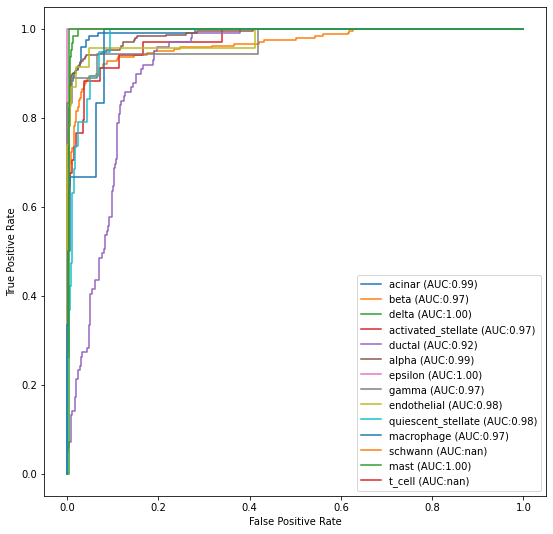

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

all_labels = list(dataset.cellToIndex.keys())
test_labels = np.array(test_labels)

for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_labels[:,idx].astype(int), predics[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

In [24]:
print(test_labels)
b = np.zeros_like(predics)
b[np.arange(len(predics)), predics.argmax(1)] = 1
print(b)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
torch.save(train_dataset, 'train_loader_aug24.pt')
torch.save(test_dataset, 'test_loader_aug24.pt')

In [8]:
model.load_state_dict(torch.load('model_weightsSept20BaronHuman.pth'))

<All keys matched successfully>

In [11]:
from sklearn.metrics import average_precision_score

def testForAUPR(loader):
    model.eval()

    correct = 0
    avgAUC = 0
    toReturn = np.zeros((len(loader), 14))
    ind = 0
    actual = np.zeros((len(loader), 14))
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.x = torch.reshape(data.x, (data.x.shape[0], 1))
        data.x = data.x.type(torch.FloatTensor)
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        wowow = average_precision_score(data.y.cpu().detach().numpy(), out.cpu().detach().numpy(), average='micro')
        print(wowowow)
    
testForAUPR(test_loader)

ValueError: multiclass format is not supported